# Processetti
<br>

-   [Overwiev Processetti](#Processetti)
-   [Person](#Person)
    -   [Richiedenti](#Richiedenti)
    -   [Testimoni](#Testimoni)
    -   [Defunti](#Defunti)
    -   [Person Name](#Names)
-   [Localisation](#Localisation)
-   [Occupation (event)](#occupation_event)
-   [Union](#Union)
-   [Social Relationship](#Social)
-   [Geographical Place](#Geo)
    -   [Gerarchizzazione](#Gerarchia)

## Librerie

>   Importazione

In [4]:
import json
import pprint
from collections import Counter
from operator import itemgetter
import csv
from dotmap import DotMap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import openpyxl
import geopandas as gpd

-----------------

## Funzioni locali

In [5]:
# pulizzia delle stringhe

def clean_up_str(string):
    a = ''
    if string:
        a = string.replace('\xa0', '').replace('  ', ' ').strip()
    return a  

In [6]:
# Funzione di elminazione delle dupplicazioni in leggenda
##  https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [7]:
# calcolo dell'anno (medio)

def date(r_col):

    lista=[]
    for v in r_col['values']:
        if v.value.timePrimitive:
            lista.append(int(v.value.timePrimitive.label[:4]))
            
    if len(lista)>=1:
        return int(np.rint(np.mean(lista)))
    else:
        return np.nan



In [8]:
# sintesi time-spen (anno medio: begin, at some time, end)

def datatio(r_col_begin, r_col_someTime, r_col_end, element):

    begin, some_time, end = date(r_col_begin), date(r_col_someTime), date(r_col_end)
    element+= [begin, some_time, end]

    return(element)

-------------

# Preparazione dei dataset


## <a id=Processetti>Overwiev Processetti</a>



#### Appertura e ispezione dei file 

In questa sezione i dati vengono ispezionati una prima volta. Vengono importati gli _output_ scaricati da Geovistory 

I file contengono il risultato di un'interrogazione fatta in Geovistory, una tabella del dominio Analysis, con lo stesso nome, fatta nella data indicata nel nome del file. Se si vuole utilizzare un nuovo file, contenente nuovi dati, va scaricarlo da Geovistory, caricato nella cartella *geovistory_query_exports* e indicare l'indirizzo corretto nella cella seguente

In [9]:
file = 'geovistory_query_exports/nb_overwiev_processetti_20220510.json'

In [10]:
# Aprire il file e attribuirlo alla variabile *data* in forma di dizionario Python

with open(file, encoding='utf-8') as json_file:
    data_pro = json.load(json_file)

In [11]:
# Creare un oggetto DotMap con lo scopo di facilitare il lavoro sul file JSON
dmp = DotMap(data_pro)

In [12]:
# Creare una variabile contenente le righe
dmp_r = dmp.rows

In [59]:
dmp_r[0]

DotMap(col_0=DotMap(entities=[DotMap(key='591_743392', fk_type=82661, project=591, fk_class=220, pk_entity=743392, fk_project=591, type_label='Manuscript', class_label='Manifestation Singleton', entity_type='peIt', entity_label='EM 04', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')]), col_1=DotMap(entities=[DotMap(key='591_999815', fk_type=739284, project=591, fk_class=503, pk_entity=999815, fk_project=591, type_label='Processetto', class_label='Expression portion', entity_type='peIt', entity_label='Processetto di Giovanni di Michele (da Cessalto)', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')]), col_2=DotMap(entity=DotMap(key='591_1006519', project=591, fk_class=631, pk_entity=1006519, time_span=DotMap(p82=DotMap(calendar='gregorian', duration='1 day', julianDay=2304495)), fk_project=591, class_label='Pre-matrimonial enquiry', entity_type='teEn', last_second=199108454399, entity_label='Giovanni di Michele (da Cessalto) ', first_second=199108368000, tmsp_last

> Riprendi descrizione
### Trasformazione e messa in piano dei dati

È necessario disporre di dati trasformati e misurati (sopprimendo in particolare i valori multipli per una singola variabile) per poter effettuare le analisi.

La seguente procedura è stata applicata per creare una nuova tabella:
- se esistevano più anni (per esempio l'anno di nascita), è stata scelta la media
- se esistevano più occupazioni, tutte sono state mantenute e separate con un segno "#".
- se esistevano più tipi di processetto, tutti sono stati mantenuti e separati con un segno "#".


Qui sotto trovate un estratto di questa nuova tabella. Questa nuova tabella viene esportata automaticamente come documento csv. Puoi accedere e scaricare questo documento nel tuo jupyter-binder. Puoi aprirlo in Excel (via csv-import) e analizzarlo anche lì. Questo potrebbe aiutare a capire la struttura della tabella appena creata.

Tradotto con www.DeepL.com/Translator (versione gratuita)
> Riprendi descrizione

In [13]:
data_pro['columns']

{'col_0': 'Volume',
 'col_1': 'Unità archivistiche',
 'col_2': 'Processetto di',
 'col_3': 'Motivation Type',
 'col_4': 'date',
 'col_5': 'Union'}

In [14]:
### Processetti list = psl

psl=[['volume', 'section', 'number_archival_units', 'pk_processetto', 'enquiry', 'motivation_type',
 'start_date','end_date', 'anno', 'id_union', 'number_union']]


for r in dmp_r:
    element = []
    # volume
    element += ['-'.join([v.entity_label for v in r.col_0.entities]) if len(r.col_0.entities)>=1 else np.nan]   

    # sezione (unità archivistica)
    element += [clean_up_str(r.col_1.entities[0].entity_label)]

    # numero di section per enquiry 
    element += [len(r.col_1.entities)]

    # enquiry 
    element += [r.col_2.entity.pk_entity, clean_up_str(r.col_2.entity.entity_label)]
   
    # motivation type
    element += [clean_up_str('; '.join([v.entity_label for v in r.col_3.entities])) if len(r.col_3.entities)>=1 else np.nan]

    # arco e anno processetto
    valor = []
    if len(r.col_4['values']) == 0:
        element += [np.nan, np.nan, np.nan]
    else:
        for v in  r.col_4['values']:
            valor.append(int(v.value.timePrimitive.label[:4]))
        element += [r.col_4['values'][0]['value'].timePrimitive.label[:10], r.col_4[
            'values'][len(r.col_4['values'])-1]['value'].timePrimitive.label[:10], round(np.mean(valor))]

    # union
    if len(r.col_5.entities)==1:
        element += [r.col_5.entities[0].pk_entity, len(r.col_5.entities)]
    elif len(r.col_5.entities)>1:
        element += ['-'.join([str(v.pk_entity) for v in r.col_5.entities]) if len(r.col_5.entities)>=1 else np.nan, len(r.col_5.entities)]  
    else:
        element += [np.nan, 0]
        
    psl.append(element)
    

df_proc = pd.DataFrame(psl[1:], columns=psl[0])  
df_proc.head()
    

        
   


,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
0,EM 04,Processetto di Giovanni di Michele (da Cessalto),1,1006519,Giovanni di Michele (da Cessalto),Stato libero di “foresto”,1597-05-23,1597-05-23,1597.0,NaN,0
1,EM 05,Processetto di Francesco di Vincenzo Moscato (...,1,1006729,"Francesco di Vincenzo Moscato (da Fabriano, te...",Stato libero di “foresto”,1598-12-27,1598-12-27,1598.0,NaN,0
2,EM 04,Processetto di Pietro di Gennaro Costinovi (da...,1,1006883,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",Stato libero di “foresto”,1597-05-26,1597-05-26,1597.0,NaN,0
3,EM 05,Processetto di Orsola di Angelo Collotis (da V...,1,1007147,Orsola di Angelo Collotis (da Visinale),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0
4,EM 05,Processetto di Ortensia di Leonardo Verona (da...,1,1007355,Ortensia di Leonardo Verona (da Venzone),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0


In [15]:
df_proc.describe(exclude=np.number)

,volume,section,enquiry,motivation_type,start_date,end_date,id_union
count,3418,3418,3418,3413,3409,3409,495
unique,23,3323,3404,12,2065,2086,492
top,EM 07,Processeto di Margherita di Matteo Paulini e d...,(no label),Stato libero di “foresto”,1620-02-16,1595-01-20,1893208
freq,502,3,10,2781,8,8,2


> Da sviluppare sulla base delle esigenze di ricerca

--------------------------------

## <a id=Person>Person</a>

In [16]:
def person_ds(file, testo):
    file = file
    testo = testo
    with open(file, encoding='utf-8') as json_file:
        data_ric = json.load(json_file)

    dmr = DotMap(data_ric)

    dmr_r = dmr.rows  

    # Richiedenti list = rl

    rl = [['pk_processetto',  'pk_person', 'person', 'qualità', 'genere', 'origini', 'anno_nascita', 'professioni' ]]


    for r in dmr_r:
        for el in r.col_0.entities:
            element = []
            element += [el.pk_entity]

            # pk_person, person, qualità, genere
            element += [r.col_1.entity.pk_entity, clean_up_str(r.col_1.entity.entity_label), testo, (
                r.col_2.entities[0].entity_label if len(r.col_2.entities)>0 else np.nan)]
            
            # origini
            element += [clean_up_str('; '.join(e.entity_label for e in r.col_3.entities)) if len(r.col_3.entities)>=1 else np.nan]

            # Anno di nascita 
            element += [date(r.col_4)]
            
            # professioni
            element += ['; '.join(e.entity_label for e in r.col_5.entities) if len(r.col_5.entities)>=1 else np.nan]
        
            
            rl.append(element)


    return  pd.DataFrame(rl[1:], columns=rl[0]) 

In [17]:
### Poichè il modello soggiacente è identico per richiedenti e tetimoni ricorrerre a una funzione per la compilazione del ds 
## Valuta l'opportunità di estendere la funzione anche hai defunti, introducendo un condizionale sul parametro testo

---------------------------

### <a id=Richiedenti>Richiedenti</a>

In [18]:
file = 'geovistory_query_exports/nb_richiedenti_20220510.json'

with open(file, encoding='utf-8') as json_file:
    data_ric = json.load(json_file)

dmr = DotMap(data_ric)

dmr_r = dmr.rows 

In [19]:
data_ric['columns']

{'col_0': 'PK_Processetto_di',
 'col_1': 'Richiedenti',
 'col_2': 'Genere',
 'col_3': 'Origine',
 'col_4': 'Età',
 'col_5': 'Professione',
 'col_6': 'Localisation'}

In [20]:
dmr_r[1].col_0


DotMap(entities=[DotMap(key='591_1006883', project=591, fk_class=631, pk_entity=1006883, time_span=DotMap(p82=DotMap(calendar='gregorian', duration='1 day', julianDay=2304498)), fk_project=591, class_label='Pre-matrimonial enquiry', entity_type='teEn', last_second=199108713599, entity_label='Pietro di Gennaro Costinovi (da Bergamo, tesser da panni)', first_second=199108627200, tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')], _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [21]:
# Conteggio del numero max di pk_processetti per persona

conteggio = []; conteggio+= [len(r.col_0.entities) for r in dmr_r]; max(conteggio)

2

In [22]:
# Richiedenti list = rl

rl = [['pk_processetto',  'pk_person', 'person', 'qualità', 'genere', 'origini', 'anno_nascita', 'professioni' ]]


for r in dmr_r:
    for el in r.col_0.entities:
        element = []
        element += [el.pk_entity]

        # pk_person, person, qualità, genere
        element += [r.col_1.entity.pk_entity, clean_up_str(r.col_1.entity.entity_label), 'richiedente', (
            r.col_2.entities[0].entity_label if len(r.col_2.entities)>0 else np.nan)]
        
        # origini
        element += [clean_up_str('; '.join(e.entity_label for e in r.col_3.entities)) if len(r.col_3.entities)>=1 else np.nan]

        # Anno di nascita 
        element += [date(r.col_4)]
        
        # professioni
        element += ['; '.join(e.entity_label for e in r.col_5.entities) if len(r.col_5.entities)>=1 else np.nan]
       
        
        rl.append(element)


df_ric = pd.DataFrame(rl[1:], columns=rl[0])
df_ric['età'] = df_ric.merge(df_proc[['pk_processetto', 'anno']], on='pk_processetto', how='left')['anno'] - df_ric['anno_nascita']
df_ric = df_ric[['pk_processetto', 'pk_person', 'person', 'qualità', 'età', 'anno_nascita', 'genere', 'origini', 'professioni']]; df_ric.head()


,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni
0,1006519,1006422,Giovanni di Michele (da Cessalto),richiedente,21.0,1576.0,Maschile,Cessalto,NaN
1,1006883,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",richiedente,21.0,1576.0,Maschile,Bergamo,cogo; tesser da panni
2,1007147,1006856,Orsola di Angelo Collotis (da Visinale),richiedente,26.0,1572.0,Femminile,Visinale,masser
3,1007355,1007216,Ortensia di Leonardo Verona (da Venzone),richiedente,25.0,1573.0,Femminile,Venzone,masser
4,1007563,1007388,"Vincenzo di Battista Betocchi (da Gandino, cas...",richiedente,26.0,1572.0,Maschile,Gandino,casariol


In [23]:
df_ric.describe(exclude=np.number)

,person,qualità,genere,origini,professioni
count,3429,3429,3422,3126,2314
unique,3424,1,2,952,409
top,"Pasqualina di Giorgio (mariner), vedova di Dom...",richiedente,Maschile,Venezia IT,masser
freq,2,3429,2560,126,204


### <a id=Testimoni>Testimoni</a>

In [24]:
file = 'geovistory_query_exports/nb_testimoni_20220510.json'

with open(file, encoding='utf8') as json_file:
    data_tes = json.load(json_file)

dmt = DotMap(data_tes)

dmt_r = dmt.rows 

In [25]:
print(data_tes['columns'])
dmt_r[0].col_1

{'col_0': 'PK_Processetto_di', 'col_1': 'Testimoni', 'col_2': 'Genere', 'col_3': 'Origine', 'col_4': 'Età', 'col_5': 'Professione', 'col_6': 'Localisation'}


DotMap(entity=DotMap(key='591_1002990', project=591, fk_class=21, pk_entity=1002990, fk_project=591, class_label='Person', entity_type='peIt', entity_label='Giuseppe di Francesco Domiziano (da Fabriano, cimador da panni)', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00'), _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [26]:
# Conteggio del numero max di pk_processetti per persona

conteggio = []; conteggio+= [len(r.col_0.entities) for r in dmt_r]; max(conteggio)

5

In [27]:
# Testimone list = rl

tl = [['pk_processetto',  'pk_person', 'person', 'qualità', 'genere', 'origini', 'anno_nascita', 'professioni' ]]


for r in dmt_r:
    for el in r.col_0.entities:
        element = []
        element += [el.pk_entity]

        # pk_person, person, qualità, genere
        element += [r.col_1.entity.pk_entity, clean_up_str(r.col_1.entity.entity_label), 'testimone', (
            r.col_2.entities[0].entity_label if len(r.col_2.entities)>0 else np.nan)]
        
        # origini
        element += [clean_up_str('; '.join(e.entity_label for e in r.col_3.entities)) if len(r.col_3.entities) else np.nan]

        # Anno di nascita 
        element += [date(r.col_4)]
        
        # professioni
        element += ['; '.join(e.entity_label for e in r.col_5.entities) if len(r.col_5.entities) else np.nan]
        
        tl.append(element)


df_tes = pd.DataFrame(tl[1:], columns=tl[0])
df_tes['età'] = df_tes.merge(df_proc[['pk_processetto', 'anno']], on='pk_processetto', how='left')['anno'] - df_tes['anno_nascita']
df_tes = df_tes[['pk_processetto', 'pk_person', 'person', 'qualità', 'età', 'anno_nascita', 'genere', 'origini', 'professioni']]; df_tes.head()

,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni
0,1006729,1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",testimone,53.0,1545.0,Maschile,Fabriano,cimador da panni
1,1006519,1006430,Pietro di Giovanni Maria (da Venezia),testimone,54.0,1543.0,Maschile,Venezia IT,NaN
2,1006519,1006438,"Antonio di Ambrogio Didano (da Bergamo, vender...",testimone,26.0,1571.0,Maschile,Bergamo,vender vin
3,1006519,1006449,"Frizerio di Antonio Zuliani (da Venezia, pesca...",testimone,38.0,1559.0,Maschile,Venezia IT,NaN
4,1006883,1006806,"Ludovico di Ludovico Morando (da Bergamo, tess...",testimone,39.0,1558.0,Maschile,Bergamo,tesser da panni


In [28]:
df_tes.describe(exclude=np.number)

,person,qualità,genere,origini,professioni
count,7026,7026,7002,6405,5479
unique,6746,1,2,1028,524
top,"Battista di Giacomo (dal Cadore, forner)",testimone,Maschile,Venezia IT,mariner
freq,5,7026,6743,1024,359


### <a id=Defunti>Defunti<a>

In [29]:
file = 'geovistory_query_exports/nb_defunti_20220510.json'

with open(file, encoding='utf-8') as json_file:
    data_def = json.load(json_file)

dmd = DotMap(data_def)

dmd_r = dmd['rows']

In [30]:
print(data_def['columns'])
dmd_r[0].col_8

{'col_0': 'Defunto', 'col_1': 'Genere', 'col_2': 'Origine', 'col_3': 'Età', 'col_4': 'Professione', 'col_5': 'Localisation', 'col_6': 'Data_morte', 'col_7': 'Luogo_morte', 'col_8': 'Union', 'col_9': 'Tipo_unione', 'col_10': 'Partner', 'col_11': 'PK_Processetto_di'}


DotMap(entities=[DotMap(key='591_1007670', fk_type=837471, project=591, fk_class=633, pk_entity=1007670, time_span=DotMap(p81b=DotMap(calendar='gregorian', duration='1 month', julianDay=2303834)), fk_project=591, type_label='Matrimonio cattolico', class_label='Union', entity_type='teEn', last_second=199053935999, entity_label='Santa vedova di Battista di Nicola, Battista di Nicola', first_second=199051257600, tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')], _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [31]:
# Defunti list = dl
#'pk_processetto', 'pk_person', 'person', 'qualità', 'età', 'anno_nascita', 'genere', 'origini', 'professioni',]]

dl = [['pk_person', 'person', 'qualità', 'genere', 'origini', 'professioni', 'anno_nascita', 'anno_morte', 'luogo_morte', 'id_union', 'union_count', 'type_union', 'pk_person(partner)', 'partner', 'pk_processetto']]

for r in dmd_r:
    element=[]

    # pk_person, person, qualità, genere, origini, professioni
    element += [r.col_0.entity.pk_entity, clean_up_str(r.col_0.entity.entity_label), 'defunto', (r.col_1.entities[0].entity_label if len(r.col_1.entities)>0 else np.nan), (
        ('; '.join(e.entity_label for e in r.col_2.entities)) if len(r.col_2.entities)>=1 else np.nan), ('; '.join(e.entity_label for e in r.col_4.entities) if len(r.col_4.entities)>=1 else np.nan)]

    # anno_nascita
    element += [date(r.col_3)]

    # anno_morte, luogo_morte
    element += [date(r.col_6), ('; '.join(e.entity_label for e in r.col_7.entities) if len(r.col_7.entities)>=1 else np.nan)]
    
    # union, conteggio_unioni, tipo unione
    element += ['-'.join([str(v.pk_entity) for v in r.col_8.entities]) if len(r.col_8.entities)>=1 else np.nan, len(r.col_8.entities), (
        '; '.join(e.entity_label for e in r.col_9.entities) if len(r.col_9.entities)>=1 else np.nan)]
    
    # pk_person(partner), partner
    ## riscrivi
    id_part, part = [], []
    for e in r.col_10.entities:
        if e.pk_entity != r.col_0.entity.pk_entity:
            id_part.append(e.pk_entity)
            part.append(clean_up_str(e.entity_label))
    element += [('-'.join(str(e) for e in id_part) if len(id_part)>=1 else np.nan), ('; '.join(part) if len(part)>=1 else np.nan)]
          
    # pk_processetto
    element += ['-'.join([str(v.pk_entity) for v in r.col_11.entities]) if len(r.col_11.entities)>=1 else np.nan]

    dl.append(element)

df_defs = pd.DataFrame(dl[1:], columns=dl[0])
df_defs.head()


          
json


<module 'json' from 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\\lib\\json\\__init__.py'>

In [32]:
df_defs.describe(exclude=np.number)

,person,qualità,genere,origini,professioni,luogo_morte,id_union,type_union,pk_person(partner),partner,pk_processetto
count,468,468,464,265,224,369,468,456,467,467,453
unique,468,1,2,143,115,216,468,4,467,467,453
top,Battista di Nicola,defunto,Maschile,Venezia IT,mariner,Venezia IT,1007670,Matrimonio cattolico,1007492,Santa vedova di Battista di Nicola,1007675
freq,1,468,347,44,49,16,1,449,1,1,1


---------------------

### <a id=Names>Person name</a>

In [33]:
file = 'geovistory_query_exports/nb_person_name_20220518.json'
with open(file, encoding='utf-8') as json_file:
    data_name = json.load(json_file)

dmpn = DotMap(data_name)
dmpn_r = dmpn.rows

In [34]:
print(data_name['columns'])
dmpn_r[21]

{'col_0': 'Entity Preview', 'col_1': 'cognome', 'col_2': 'Titolo di rispetto', 'col_3': 'Titolo professionale'}


DotMap(col_0=DotMap(entity=DotMap(key='591_1007723', project=591, fk_class=21, pk_entity=1007723, fk_project=591, class_label='Person', entity_type='peIt', entity_label='Giulio di Giacomo Robaziri (da Bergamo, cerusico)', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')), col_1=DotMap(entities=[DotMap(key='591_1007736', fk_type=741575, project=591, fk_class=868, pk_entity=1007736, time_span=DotMap(), fk_project=591, type_label='Cognome', class_label='Person Appellation in a Language', entity_type='teEn', entity_label='Robaziri', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')]), col_2=DotMap(entities=[DotMap(key='591_1007731', fk_type=746080, project=591, fk_class=868, pk_entity=1007731, time_span=DotMap(), fk_project=591, type_label='Titolo di rispetto o di cerimonia', class_label='Person Appellation in a Language', entity_type='teEn', entity_label='ser', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')]), col_3=DotMap(entities=[]), _ipython_display_=Dot

In [35]:

def bon_str(string):
    if type(string) == str and (string != ''):
        string = string.strip().replace('\xa0', '').replace('  ', ' ').lower()
    return string

# Person name list = pnl

pnl = [['pk_person', 'person', 'cognome', 'cognome_count', 'titolo_rispetto', 'titolo_profesisonale']]

for r in dmpn_r:
    element = []
    element += [r.col_0.entity.pk_entity, r.col_0.entity.entity_label, clean_up_str('; '.join(c.entity_label for c in r.col_1.entities)), len(r.col_1.entities) , bon_str('; '.join(tr.entity_label for tr in r.col_2.entities)),
     bon_str('; '.join(tp.entity_label for tp in r.col_3.entities))]
    pnl.append(element)

df_name = pd.DataFrame(pnl[1:], columns=pnl[0])
df_name.replace('', np.nan, inplace=True)




In [36]:
df_name.loc[(df_name.cognome_count>1) & (df_name.cognome.str.contains('(?i)domin|(?i)ser'))]

,pk_person,person,cognome,cognome_count,titolo_rispetto,titolo_profesisonale
57,1012149,"Ludovico di Faustino Faustini (da Pregasio, sp...",ser; Faustini,2,NaN,NaN
393,1054933,Marietta di Antonio Gastaldione (da Flagogna),Gastaldione; Domina,2,NaN,NaN
1762,1147200,"Nicolò di Pompeo Baldi (da Ghedi, tesser da pa...",ser; Baldi,2,NaN,NaN
2263,1249404,"Cristiano di Giacomo Forame (da Livinallongo, ...",Ser; Forame (de),2,NaN,NaN
3171,1464762,Santo di Luciano Zanieli (da Potenza),Zanieli; domino,2,NaN,NaN
3270,1475954,"Giacomo di Floriano Rivolini (dalla Carnia, te...",ser; Rivolini,2,NaN,NaN
3586,1506247,"Cristoforo di Retini Sivi (da Redona, barbier)",Sivi; domino,2,NaN,NaN
5556,1743295,Federico di Simone Zanchi (tesser da panni),Ser; Zanchi,2,NaN,NaN
6352,1807799,"Marsilio di Bernardino Fontana (veronese, murer)",Domino ; Fontana,2,NaN,NaN
6419,1811411,Nicolò di Giovanni Parmesan (da Almissa),Parmesan; Domino,2,NaN,NaN


In [37]:
df_name.loc[(df_name.cognome_count>1) & (df_name.cognome.str.contains('(?i)domin|(?i)ser')==False)]

,pk_person,person,cognome,cognome_count,titolo_rispetto,titolo_profesisonale
183,1039703,Margherita di Baldo Balzar (da Cerete Basso),Balzar; Balssar,2,NaN,NaN
282,1046945,"Ludovico di Giuseppe Brunelleschi (da Venezia,...",Brunelleschi; Burnelesco,2,domino,NaN
403,1055490,Francesco di Giovanni Giacomo Turchi (da Cellore),Turchi; Turchi (de),2,NaN,NaN
409,1055644,"Camillo di Bartolomeo Pivati (da Venezia, tess...",Pivati (de); Pivatti (de),2,NaN,NaN
475,1059661,Carlo Polini (bolognese),Pollinus; Polini,2,domino,NaN
...,...,...,...,...,...,...
10240,756015,Giovanna di Battista De Zuliani vedova di Batt...,De Zuliani; De Pizzolesi,2,NaN,NaN
10308,761131,Vincenzo di Antonio De Caballis (mariner),De Cavalli; De Caballis,2,NaN,NaN
10354,764640,"Carlo di Giovanni Riese (da Villach, interpr...",Riese (Ariss); Gigante,2,ser,NaN
10495,773122,Adriana Motta vedova di Domenico Carnaris (da ...,Motta; Carnaris,2,NaN,NaN


In [38]:
df_name['titolo_rispetto'].unique()

array([nan, 'ser', 'domina', 'domino', 'clarissimo', 'clarissima',
       'domino; domino', 'reverendo presbitero; domino',
       'domino; reverendo presbitero', 'vir honestissimus dominus',
       'clarissimo domino', 'clarissima domina', 'reverendo; domino',
       'messer', 'magnifico', 'magnifico domino',
       'illustrissimo e reverendissimo', 'domino; magnifico', 'reverendo',
       'reverendo presbitero', 'domino; clarissimo', 'ser; domino',
       'conte; clarissimo domino',
       'cittadino veneziano; magnifico domino', 'maestro',
       'domino/domina', 'illustrissimo', 'magnifica domina',
       'nobile veneto; clarissimo domino',
       'nobile vicentino; magnifico domino', 'cornari', 'messer dominus',
       'presbitero; domino', 'magnifico; reverendo presbitero', 'strenuo',
       'nobile domina', 'doomina', 'eccellentissimo domino',
       'eccellente domino',
       'ser; ventura di lorenzo sbotta (da gandino, laner)', 'nobile',
       'signora', 'eccellentissimo ; m

In [39]:
df_name.titolo_profesisonale.unique()

array([nan, 'maestro', 'prete', 'reverendo presbitero', 'presbitero',
       'patron', 'ser', 'magister', 'capitano',
       'dottotre (artium et medicinae doctor)', 'ambasciatore',
       'reverendo', 'reverendo pre'], dtype=object)

### Note:

Includi nella query *__cognome__*, *__titolo di rispetto__* e *__titolo professionale__*
>   Integra codice  

----------------------

## <a id=Localisation>Localisation</a>

In [40]:
file = 'geovistory_query_exports/nb_loclaisation_20220512.json'

with open(file, encoding='utf-8') as json_file:
    data_loc = json.load(json_file)

dml = DotMap(data_loc)

dml_r = dml.rows

In [41]:
print(data_loc['columns'], '\n')

for r in dml_r:
    
    if len(r.col_8.entities)>0:
        print(r.col_8)
        break
    


{'col_0': 'Entity Preview', 'col_1': 'Person', 'col_2': 'Localisation', 'col_3': 'Begin earliest', 'col_4': 'Begin leterst', 'col_5': 'At some time within', 'col_6': 'End earliest', 'col_7': 'End leaterst', 'col_8': 'Occours before', 'col_9': 'Occours after', 'col_10': 'Type', 'col_11': 'Localisation_type', 'col_12': 'Geocoordinate'} 

DotMap(entities=[DotMap(key='591_1011924', fk_type=925607, project=591, fk_class=212, pk_entity=1011924, time_span=DotMap(p82=DotMap(calendar='gregorian', duration='1 month', julianDay=2305083)), fk_project=591, type_label='Abitazione e luogo di lavoro   ', class_label='Geographical Location of a Physical Thing', entity_type='teEn', last_second=199161849599, entity_label='Antonio di Antonio Murla (da Fonzaso, samiter)   , S. Geremia', first_second=199159171200, tmsp_last_modification='2022-05-06T06:41:13.83725+00:00')])


In [42]:
# Localisation list = ll

ll = [['id_locaisation', 'pk_person', 'person', 'geographical_place', 'GP_type', 'lat', 'lon', 'localisation_type', 'begin', 'at_some_time', 'end', 'occours_before', 'occours_after']]

for r in dml_r:
    element = []

    # id_localisatio, pk_person, person, geo_place + (id), 
    ## valuta la comodità di tenere separato l'ID geographical Place, geographical place, type, coordinate (x,y), localization type 
    element += [r.col_0.entity.pk_entity, r.col_1.entities[0].pk_entity, clean_up_str(r.col_1.entities[0].entity_label), (r.col_2.entities[0].entity_label + f' ({ r.col_2.entities[0].pk_entity})')  if len(
        r.col_2.entities)>0 else np.nan, r.col_10.entities[0].entity_label if len(r.col_10.entities)>=1 else np.nan]
    if len(r.col_12['values'])>0:    
        element += [r.col_12['values'][0].value.geometry.geoJSON.coordinates[0], r.col_12['values'][0].value.geometry.geoJSON.coordinates[1]]
    else:
        element +=[np.nan, np.nan]
    element += [r.col_11.entities[0].entity_label if len(r.col_11.entities)>0 else np.nan]

    # Begin
    element += [round(np.mean([int(r.col_3['values'][0].value.timePrimitive.label[:4]), int(r.col_4['values'][0].value.timePrimitive.label[:4])])) if (len(r.col_3['values'])>0) and (len(r.col_4['values'])>0) else int(
        r.col_3['values'][0].value.timePrimitive.label[:4]) if (len(r.col_3['values'])>0) else int(r.col_4['values'][0].value.timePrimitive.label[:4]) if len(r.col_4['values'])>0 else np.nan]
    
    # At some time within
    element += [int(r.col_5['values'][0].value.timePrimitive.label[:4]) if len(r.col_5['values'])>0 else np.nan]

    # End
    element += [round(np.mean([int(r.col_6['values'][0].value.timePrimitive.label[:4]), int(r.col_7['values'][0].value.timePrimitive.label[:4])])) if (len(r.col_6['values'])>0) and (len(r.col_7['values'])>0) else int(
        r.col_6['values'][0].value.timePrimitive.label[:4]) if (len(r.col_6['values'])>0) else int(r.col_7['values'][0].value.timePrimitive.label[:4]) if len(r.col_7['values'])>0 else np.nan]
  
  
    # Occours before
    element += ['-'.join(str(v.pk_entity) for v in r.col_8.entities) if len(r.col_8.entities)>0 else np.nan]
    
    # Occours after
    element += ['-'.join(str(v.pk_entity) for v in r.col_9.entities) if len(r.col_9.entities)>0 else np.nan]
    
    ll.append(element)

df_loc = pd.DataFrame(ll[1:], columns=ll[0])
df_loc.head()    


,id_locaisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after
0,1006461,1006422,Giovanni di Michele (da Cessalto),S. Nicolò (743132),Parrocchia,12.315848,45.432772,Abitazione,NaN,1597.0,NaN,NaN,NaN
1,1006467,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",S. Marziale (743039),Parrocchia,12.332900,45.443800,Abitazione,NaN,1598.0,NaN,NaN,NaN
2,1006473,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",Venezia IT (209678),Città,12.332650,45.437130,Abitazione,1591.0,NaN,NaN,NaN,NaN
3,1006478,1006422,Giovanni di Michele (da Cessalto),Venezia IT (209678),Città,12.332650,45.437130,Abitazione,1586.0,NaN,NaN,NaN,NaN
4,1006544,1006430,Pietro di Giovanni Maria (da Venezia),S. Nicolò (743132),Parrocchia,12.315848,45.432772,Abitazione,NaN,1597.0,NaN,NaN,NaN


> semplifica query in Geovistory: ridurre time-span

In [43]:
df_loc.describe(exclude=np.number)

,person,geographical_place,GP_type,localisation_type,occours_before,occours_after
count,14880,14868,14861,14828,172,169
unique,9508,227,7,5,170,169
top,Lucrezia Sanudo (capodistriana),Venezia IT (209678),Parrocchia,Abitazione,1084859,1012100
freq,6,5229,9151,13818,2,1


In [44]:
# Definire geometrie (punto) a partire da coordinate  
geodf_loc= gpd.GeoDataFrame(df_loc, geometry=gpd.points_from_xy(df_loc.lon, df_loc.lat))
geodf_loc.head(3)

,id_locaisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after,geometry
0,1006461,1006422,Giovanni di Michele (da Cessalto),S. Nicolò (743132),Parrocchia,12.315848,45.432772,Abitazione,NaN,1597.0,NaN,NaN,NaN,POINT (45.43277 12.31585)
1,1006467,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",S. Marziale (743039),Parrocchia,12.332900,45.443800,Abitazione,NaN,1598.0,NaN,NaN,NaN,POINT (45.44380 12.33290)
2,1006473,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",Venezia IT (209678),Città,12.332650,45.437130,Abitazione,1591.0,NaN,NaN,NaN,NaN,POINT (45.43713 12.33265)


In [45]:
df_confinio = gpd.read_file(filename='shapefile/confinio.shp')
df_edifici = gpd.read_file(filename='shapefile/edifici.shp')
df_confinio.head()

,fid,id,NAME,SESTIERE,ID_sestier,geometry
0,1.0,64.0,S. Maria del Giglio,S.Marco,945760.0,"POLYGON ((2311311.430 5034369.281, 2311318.930..."
1,2.0,65.0,S. Maurizio,S.Marco,945760.0,"POLYGON ((2311189.734 5034376.081, 2311188.834..."
2,3.0,66.0,S. Vidal,S.Marco,945760.0,"POLYGON ((2311061.048 5034421.206, 2311002.806..."
3,4.0,67.0,S. Samuele,S.Marco,945760.0,"POLYGON ((2311002.806 5034485.838, 2310987.039..."
4,5.0,68.0,S. Angelo,S.Marco,945760.0,"POLYGON ((2311155.483 5034806.288, 2311260.332..."


c:\Users\Jacopo COSSU\anaconda_surrogato\v_env_surog\lib\site-packages\geopandas\plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(
c:\Users\Jacopo COSSU\anaconda_surrogato\v_env_surog\lib\site-packages\geopandas\plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


<AxesSubplot:>

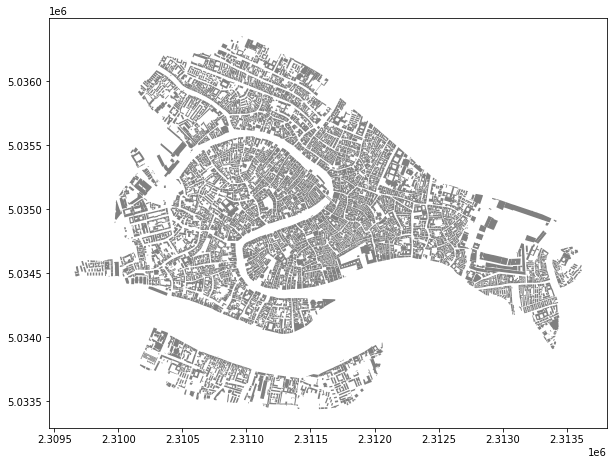

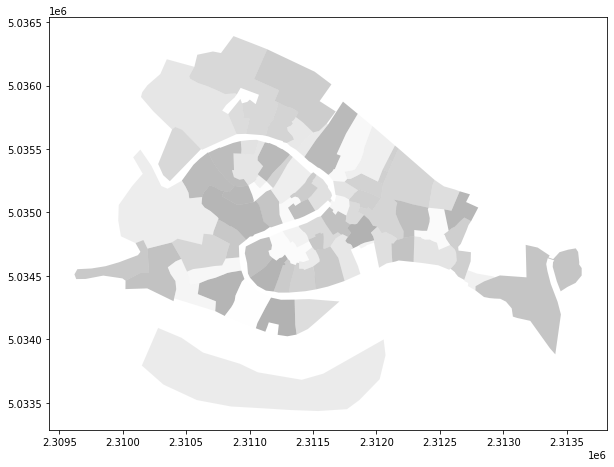

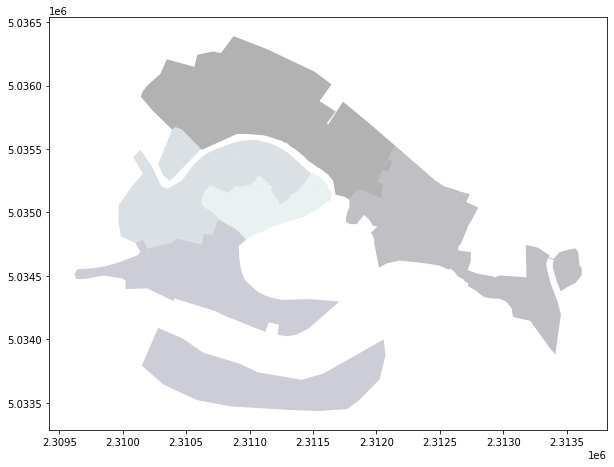

In [46]:
df_edifici.plot(figsize=(10,10),color='grey' )
df_confinio.plot('NAME', figsize=(10,10), legend=False, colormap='gist_yarg', alpha  = 0.3)
df_confinio.plot('SESTIERE', figsize=(10,10), legend=False, colormap='bone', alpha  = 0.3)


In [47]:
df_confinio.crs

<Derived Projected CRS: EPSG:3004>
Name: Monte Mario / Italy zone 2
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

c:\Users\Jacopo COSSU\anaconda_surrogato\v_env_surog\lib\site-packages\geopandas\plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


Text(0.5, 1.0, 'Venenzia XVII sec.')

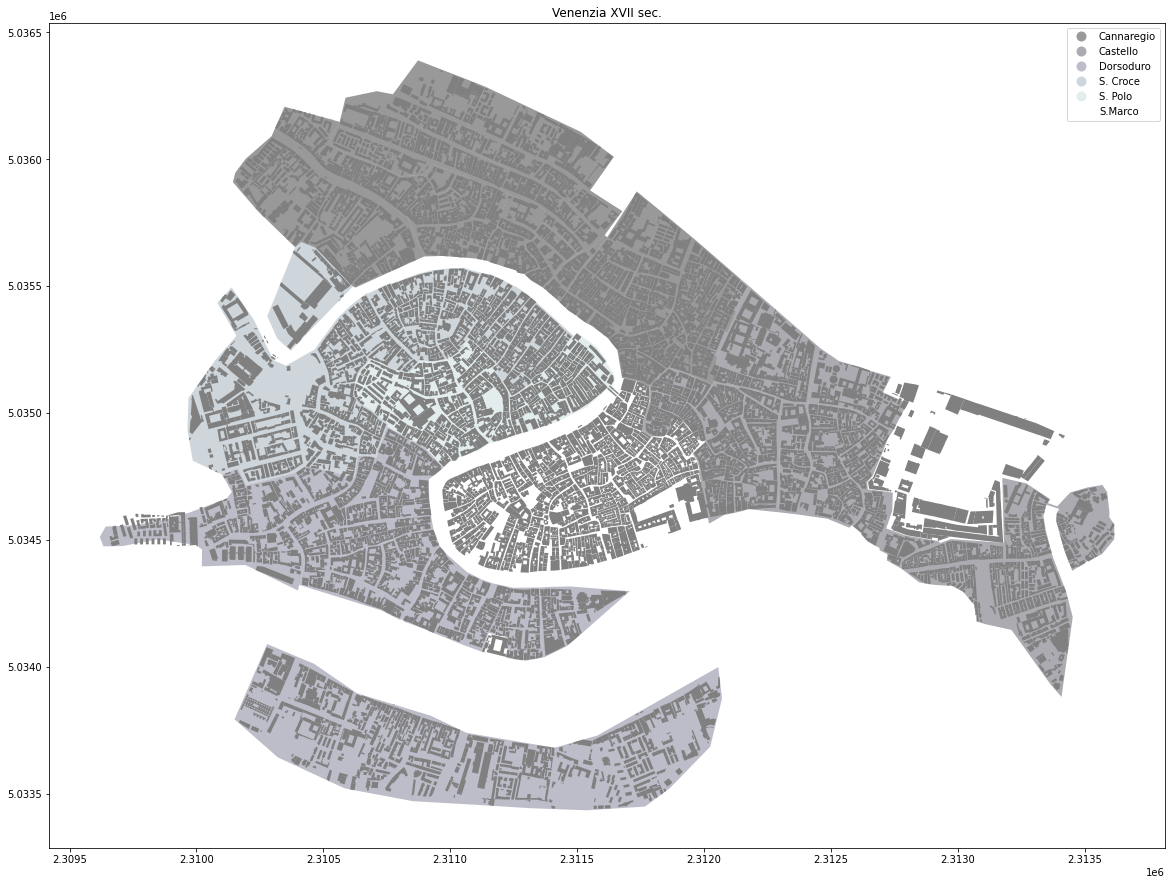

In [48]:
fig, ax = plt.subplots(figsize=(20,20))

df_confinio.plot('SESTIERE', ax=ax, legend=True, colormap='bone', alpha  = 0.4)
df_edifici.plot(ax=ax, color='grey')
ax.set_title('Venenzia XVII sec.')

## <a id=occupation_event>Occupation (event)<a>

In [49]:
file = 'geovistory_query_exports/nb_occupation_event_20220512.json'

with open(file, encoding='utf-8') as json_file:
    data_occup = json.load(json_file)

dmoe = DotMap(data_occup)
dmoe_r = dmoe.rows

In [50]:
print(data_occup['columns'], '\n')
dmoe_r[0].col_3

for r in dmoe_r:
    if len(r.col_5['values'])>0:
        print(r.col_5)
        break


{'col_0': 'Person', 'col_1': 'Occupation (event)', 'col_2': 'Occupation', 'col_3': 'Begin', 'col_4': 'End', 'col_5': 'At some time', 'col_6': 'Occurs before', 'col_7': 'Occurs after'} 

DotMap(values=[DotMap(value=DotMap(timePrimitive=DotMap(to=DotMap(calJulian='1599-01-22', julianDay=2305114, calGregorian='1599-02-01', julianSecond=199161849600, calGregorianIso8601='1599-02-01T00:00:00Z'), from=DotMap(calJulian='1598-12-22', julianDay=2305083, calGregorian='1599-01-01', julianSecond=199159171200, calGregorianIso8601='1599-01-01T00:00:00Z'), label='1599-01-01 (1 month)', fkClass=335, calendar='gregorian', duration='1 month', pkEntity=1007929, julianDay=2305083)), pkStatement=1008309, fkObjectInfo=1007929, fkSubjectInfo=1008293)])


In [51]:
# Occupation event list = oel

oel = [['pk_person', 'person', 'id_occup_event','id_occupation' ,'occupation', 'begin', 'at_some_time', 'end', 'occours_before', 'count_OB', 'occours_after', 'count_OA']]

for r in dmoe_r:
    element = []

    # pk_person, person
    if len(r.col_0.entities)>0:
        element += [str(r.col_0.entities[0].pk_entity) , clean_up_str(r.col_0.entities[0].entity_label)]
    else:
        element += [np.nan, np.nan]
    
    # id occupation event, id_occupation, occupation
    element += [r.col_1.entity.pk_entity, r.col_2.entities[0].pk_entity if len(r.col_2.entities)>0 else np.nan, r.col_2.entities[0].entity_label if len(r.col_2.entities)>0 else np.nan]

    # Begin, At some time within, End
    datatio(r.col_3, r.col_5, r.col_4, element)

    '''
    # Begin
    # riscrivi
    if len(r.col_3['values'])==1:
        element += [int(r.col_3['values'][0].value.timePrimitive.label[:4])]
    elif len(r.col_3['values'])>1:
        element += [round(np.mean([int(r.col_3['values'][0].value.timePrimitive.label[:4]), int(r.col_3['values'][1].value.timePrimitive.label[:4])]))]
    else:
        element += [np.nan]
    
    
    # At some time within
    element += [int(r.col_5['values'][0].value.timePrimitive.label[:4]) if len(r.col_5['values'])!=0 else np.nan]

    # End
    ## riscrivi
    if len(r.col_4['values'])==1:
        element += [int(r.col_4['values'][0].value.timePrimitive.label[:4])]
    elif len(r.col_4['values'])>1:
        element += [round(np.mean([int(r.col_4['values'][0].value.timePrimitive.label[:4]), int(r.col_4['values'][1].value.timePrimitive.label[:4])]))]
    else:
        element += [np.nan]
    '''
    
    # Occours before, conteggio (OB),  Occours after, conteggio(OA)
    element += ['-'.join(str(v.pk_entity) for v in r.col_6.entities) if len(r.col_6.entities)>0 else np.nan, len(r.col_6.entities), '-'.join(str(v.pk_entity) for v in r.col_7.entities) if len(r.col_7.entities)>0 else np.nan, len(r.col_7.entities)]
    
    oel.append(element)
    
df_oce = pd.DataFrame(oel[1:], columns=oel[0])
df_oce.head()



,pk_person,person,id_occup_event,id_occupation,occupation,begin,at_some_time,end,occours_before,count_OB,occours_after,count_OA
0,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",1006497,754083.0,mercante,NaN,NaN,NaN,NaN,0,NaN,0
1,1006438,"Antonio di Ambrogio Didano (da Bergamo, vender...",1006594,774132.0,vender vin,NaN,NaN,NaN,NaN,0,NaN,0
2,1006449,"Frizerio di Antonio Zuliani (da Venezia, pesca...",1006620,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3,1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",1006641,749783.0,cimador da panni,NaN,NaN,NaN,NaN,0,NaN,0
4,999599,"Francesco di Vincenzo Moscato (da Fabriano, te...",1006738,763241.0,tentor,NaN,NaN,NaN,NaN,0,NaN,0


In [52]:
df_oce.describe(exclude=np.number)

,pk_person,person,occupation,occours_before,occours_after
count,8174,8174,8116,97,97
unique,7878,7875,506,95,95
top,1148703,Battista Melada (portador da vin),mariner,1046024,1148837
freq,4,4,632,2,3


In [53]:
file = 'geovistory_query_exports/activiti_dom.json'
with open(file, encoding='utf-8') as json_file:
    data_domain = json.load(json_file)

dmd = DotMap(data_domain)
dmd_r = dmd.rows

# act_domain list = adl
adl = [['id_occupation', 'occupation', 'broder_occupation', 'activity_domain', 'broder_activity']]
for row in dmd_r:
    element = []
    element += [row.col_0.entity.pk_entity, row.col_0.entity.entity_label]
    if len(row.col_1.entities)>=1:
        ocupations=[]
        for e in row.col_1.entities:
            ocupations +=[e.entity_label]
        element += [ocupations]
    else:
        element += [np.nan]
    if row.col_2.entities:
        activity=[]
        for e in row.col_2.entities:
            activity += [e.entity_label]
        element += [activity]
    else:
        element += [np.nan]
    if row.col_3.entities:
        activity_bt=[]
        for e in row.col_3.entities:
            activity_bt += [clean_up_str(e.entity_label)]
        element += [activity_bt]
    else:
        element += [np.nan]
    
    adl.append(element)
   

df_actdom = pd.DataFrame(adl[1:], columns=adl[0])
df_actdom
   
    


,id_occupation,occupation,broder_occupation,activity_domain,broder_activity
0,1007057,sanser,NaN,"[Servizi legali, commerciali ed amministrativi]",NaN
1,1007097,fante ai Censori,[fante],"[Servizi nella pubblica amministrazione, nelle...",NaN
2,1007587,guardian,NaN,"[Servizi nella pubblica amministrazione, nelle...",NaN
3,1007707,cerusico,NaN,[Salute e cura del corpo],NaN
4,1008218,stampador da libri,[stampador],[Editoria e stampa],NaN
...,...,...,...,...,...
459,998125,masser della nave,NaN,"[Trasporti e comunicazioni, Attività marittima]",NaN
460,998291,scalco da nave,[scalco],"[Attività marittima, Pulizia e servizio domest...",NaN
461,998979,erbariol,NaN,[Commercio di generi alimentari e bevande],"[Commercio, Generi alimentari e bevande (setto..."
462,999039,lavorador da zucchero,NaN,[Produzione di generi alimentari e bevande],[Generi alimentari e bevande (settore)]


In [ ]:
### Riprendi da qui 

## <a id=Union>Union</a>

In [ ]:
file = 'geovistory_query_exports/nb_union_20220517.json'

with open(file, encoding='utf-8') as json_file:
    data_union = json.load(json_file)

dmu = DotMap(data_union)

dmu_r = dmu.rows

In [ ]:
print(data_union['columns'])
dmu_r[7].col_2

{'col_0': 'Pk_Processetto_di', 'col_1': 'Entity Preview', 'col_2': 'Partner', 'col_3': 'Union_type', 'col_4': 'Begin', 'col_5': 'Some_Time', 'col_6': 'End', 'col_7': 'Stem'}


DotMap(entities=[DotMap(key='591_1038812', project=591, fk_class=21, pk_entity=1038812, fk_project=591, class_label='Person', entity_type='peIt', entity_label='Antonio di Giacomo Dalla Valle (da Cerete Basso)', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00'), DotMap(key='591_1039703', project=591, fk_class=21, pk_entity=1039703, fk_project=591, class_label='Person', entity_type='peIt', entity_label='Margherita di Baldo Balzar (da Cerete Basso)', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')], _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [ ]:
# funzione particolare 

def individuazione_partner(r_col, element):
    
    if len(r_col.entities)>1:
                for p in r_col.entities:
                    if p.pk_entity != element[2]:
                       element += [p.pk_entity, clean_up_str(p.entity_label)]
    else:
        element += [np.nan, 'missing']
    return(element)



# Union list = ul

ul = [['pk_processetto', 'id_union', 'pk_person',  'person', 'qualità', 'pk_secondPerson', 'secondPerson', 'begin', 'at_some_time', 'end']]

for r in dmu_r:
    
    if len(r.col_0.entities)>0:
        for e in r.col_0.entities:
            element = [] 
            element += [e.pk_entity, r.col_1.entity.pk_entity]
            for p in r.col_2.entities:
                if p.entity_label == e.entity_label:
                    element += [p.pk_entity, clean_up_str(p.entity_label), 'richiedente']
            individuazione_partner(r.col_2, element)
            datatio(r.col_4, r.col_5, r.col_6, element)
            ul.append(element)          
    else:
        element = [np.nan, r.col_1.entity.pk_entity, r.col_2.entities[0].pk_entity if len(r.col_2.entities)>0 else np.nan, clean_up_str(r.col_2.entities[0].entity_label) if len(r.col_2.entities)>0 else 'missing', 'altro']
        individuazione_partner(r.col_2, element)
        datatio(r.col_4, r.col_5, r.col_6, element)
        ul.append(element) 
    
df_union = pd.DataFrame(ul[1:],columns=ul[0])
df_union.head()

,pk_processetto,id_union,pk_person,person,qualità,pk_secondPerson,secondPerson,begin,at_some_time,end
0,1007675.0,1007670,1007492.0,Santa vedova di Battista di Nicola,richiedente,1007544.0,Battista di Nicola,NaN,NaN,1595.0
1,1007777.0,1007767,1007715.0,Filippo Amis (da Bergamo),richiedente,1007750.0,Angela (da Bergamo),NaN,NaN,1596.0
2,1026527.0,1026547,1012979.0,Caterina Albrizzi vedova di Francesco Bettinel...,richiedente,1013001.0,Francesco Bettinelli (curamer),NaN,NaN,1591.0
3,1032502.0,1032511,1032116.0,Bradamante di Francesco Canano (da Pordenone) ...,richiedente,1032159.0,Marco Antonio di Francesco Galeotto,1575.0,NaN,1590.0
4,1036286.0,1038311,1036219.0,Bernardo di Virgilio Cauzio (da Velle di Ledro...,richiedente,NaN,missing,NaN,NaN,NaN


In [ ]:
df_union.describe(exclude=np.number)

,person,qualità,secondPerson
count,558,558,558
unique,545,2,529
top,missing,richiedente,missing
freq,5,538,27


In [ ]:
df_union[df_union.person=='missing']

,pk_processetto,id_union,pk_person,person,qualità,pk_secondPerson,secondPerson,begin,at_some_time,end
56,NaN,1108833,NaN,missing,altro,NaN,missing,NaN,NaN,1597.0
266,NaN,1789911,NaN,missing,altro,NaN,missing,NaN,NaN,NaN
529,NaN,837480,NaN,missing,altro,NaN,missing,NaN,NaN,NaN
530,NaN,873810,NaN,missing,altro,NaN,missing,NaN,NaN,NaN
542,NaN,927723,NaN,missing,altro,NaN,missing,1595.0,NaN,NaN


## <a id=Social>Social Relationship</a>

In [ ]:
file = 'geovistory_query_exports/nb_social_relationship_20220512.json'

with open(file, encoding='utf-8') as json_file:
    data_srel = json.load(json_file)

dmsr = DotMap(data_srel)
dmsr_r = dmsr.rows

In [ ]:
print(data_srel['columns'], '\n')
dmsr_r[0].col_2

{'col_0': 'Pk_Processetto_di', 'col_1': 'Richiedente', 'col_2': 'Defunto', 'col_3': 'Union', 'col_4': 'Social relationship', 'col_5': 'Social relationship type', 'col_6': 'Partners (symmetrical)', 'col_7': 'Relationship source', 'col_8': 'Relationship target', 'col_9': 'Begin', 'col_10': 'At some time', 'col_11': 'End'} 



DotMap(entities=[], _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [ ]:
for r in dmsr_r:
    if len(r.col_8['entities'])>1:
        print(r.col_8)
        break

DotMap(entities=[DotMap(key='591_1079098', project=591, fk_class=21, pk_entity=1079098, fk_project=591, class_label='Person', entity_type='peIt', entity_label='Gregorio di Martino Maretti (profumier)', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00'), DotMap(key='591_1079113', project=591, fk_class=21, pk_entity=1079113, fk_project=591, class_label='Person', entity_type='peIt', entity_label='Elisabetta di Leonardo Ventura (profumier)   ', tmsp_last_modification='2022-05-05T06:40:28.316247+00:00')])


**1.**

| pk_proc | richiedente | defunto | ruolo nella relazione | altro partner | source | target | 
|--|--|--|--|--|--|--|
| 1:n | `null` | `null` | `null` | [*] | 0 | 0 
| 1:n | `null` | `null` | `null` | 0 | 1 | 1 | | 
| 1:n | 0 ; 1 | 1 ; 0 | 'partner' | 1 | 0 | 0 | | 
| 1:n | 0 ; 1 | 1 ; 0 | 'source' | 0 | 0 | 1 | | 
| 1:n | 0 ; 1 | 1 ; 0 | 'target' | 0 | 1 | 0 | |

<br>

**2.**

| pk_proc | pk_person | qualità | ruolo nella relazione | partner (1) | partner(2) | source | target | descrizione |
|--|--|--|--|--|--|--|--|--|


<br>

**3.**

|pk_proc | pk_person | qualità | ruolo nella relazione | partner/source | partner/source | tipo di relazione |
|--|--|--|--|--|--|--|
| 1:n | 0 ; 1 | richiedente/defunto/altro | partner/source/target | 1 | 1 | simmetrica/direzionata | 

<br>

**4.**

|pk_proc | qualità | person | ruolo nella relazione | person | ruolo nella relazione | tipo di relazione |
|--|--|--|--|--|--|--|
| 1 |   defunto/testimone/altro | [person] |   partner/source/target   | [person] | partner/source/target    | simmetrica/direzionata    |

#### Riscrivi:

In [ ]:
# Da riscrivere. Il flusso può essere razionalizzato e snellito 

# funzione particolare

def integratio_sr(element):    
    if len(r.col_6.entities)==2:
        for el in r.col_6.entities:
                if (el.pk_entity) != element[1]:
                    element += ['partner', el.pk_entity, clean_up_str(el.entity_label)]
    elif len(r.col_6.entities)==1:
        if (r.col_6.entities[0].pk_entity) != element[1]:
            element += ['error', r.col_6.entities[0].pk_entity, clean_up_str(r.col_6.entities[0].entity_label)]
        else:
            if len(r.col_7.entities) >0:
                element += ['error', r.col_7.entities[0].pk_entity, clean_up_str( r.col_7.entities[0].entity_label)]
            else:
                if len(r.col_8.entities) >0:
                    element += ['error', r.col_8.entities[0].pk_entity, clean_up_str( r.col_8.entities[0].entity_label)]
                else:
                    element += ['error', np.nan, np.nan]
    elif len(r.col_6.entities) >2:
        i=0
        while i in range(len(r.col_6.entities)):
            for el in r.col_6.entities:
                if (el.pk_entity) != element[1]:
                    element += ['error', el.pk_entity, clean_up_str(el.entity_label)]
                    break
                else:
                    i+=1
            break
        if i == len(r.col_6.entities):
            element += ['error', r.col_6.entities[0].pk_entity, clean_up_str(r.col_6.entities[0].entity_label)]
    else:
        if len(r.col_7.entities)>0:
            if len(r.col_7.entities) ==1:
                if (r.col_7.entities[0].pk_entity) != element[1]:
                    element += ['target', r.col_7.entities[0].pk_entity, clean_up_str(r.col_7.entities[0].entity_label)]
                else:
                    if len(r.col_8.entities)>0:     # ridondante
                        if len(r.col_8.entities)==1:
                            if (r.col_8.entities[0].pk_entity) != element[1]:
                                element += ['source', r.col_8.entities[0].pk_entity, clean_up_str(r.col_8.entities[0].entity_label)]
                            else: 
                                element += ['error', r.col_8.entities[0].pk_entity, clean_up_str(r.col_8.entities[0].entity_label)]
                        elif len(r.col_8.entities)>1:
                            i=0
                            while i in range(len(r.col_8.entities)):
                                for el in r.col_8.entities:
                                    if (el.pk_entity) != element[1]:
                                        element += ['error', el.pk_entity, clean_up_str(el.entity_label)]
                                        break
                                    else:
                                        i+=1
                                break
                            if i == len(r.col_8.entities):
                                element += ['error', r.col_8.entities[0].pk_entity, clean_up_str(r.col_8.entities[0].entity_label)]
            elif len(r.col_7.entities) > 1:
                i=0
                while i in range(len(r.col_7.entities)):
                    for el in r.col_7.entities:
                        if (el.pk_entity) != element[1]:
                            element += ['error', el.pk_entity, clean_up_str(el.entity_label)]
                            break
                        else:
                            i+=1
                    break
                if i == len(r.col_7.entities):
                    element += ['error', r.col_7.entities[0].pk_entity, clean_up_str(r.col_7.entities[0].entity_label)]
        else:
            if len(r.col_8.entities)>1:
                i=0
                while i in range(len(r.col_8.entities)):
                    for el in r.col_8.entities:
                        if (el.pk_entity) != element[1]:
                            element += ['error', el.pk_entity, clean_up_str(el.entity_label)]
                            
                            break
                        else:
                            i+=1
                    break
                if i == len(r.col_7.entities):
                    element += ['error', r.col_8.entities[0].pk_entity, clean_up_str(r.col_8.entities[0].entity_label)]
            elif len(r.col_8.entities)==0:
                element += ['error', np.nan, np.nan]
            else:
                element += ['error', r.col_8.entities[0].pk_entity, clean_up_str(r.col_8.entities[0].entity_label)]

    element += [r.col_4.entity.pk_entity, r.col_5.entities[0].entity_label if len(r.col_5.entities)>0 else np.nan]

     

# Social Relationship list = srl

srl =[['pk_processetto', 'pk_person', 'person', 'qualità', 'ruolo', 'pk_secondPerson', 'secondPerson', 'id_relazione', 'relation_type', 'begin', 'at_some_time', 'end']]


# pk_processetto/pk_processetto(union), pk_person, person_name, qualità
## Essendo la query definita a partire dalle Social Relationship, possono essere riportati più enquiry di validita (es. quando la relazione intercorre tra due richiedenti)
for r in dmsr_r:
    i = 0
    if len(r.col_0.entities) >= 1:
        for el in r.col_0.entities:
            element = []
            element += [el.pk_entity, r.col_1.entities[i].pk_entity if len(r.col_1.entities)>i else r.col_1.entities[(i-1)].pk_entity, clean_up_str(r.col_1.entities[(i)].entity_label) if len(
                r.col_1.entities)>i else clean_up_str(r.col_1.entities[(i-1)].entity_label), 'richiedente']
            i+=1
            integratio_sr(element)
            datatio(r.col_9, r.col_10, r.col_11, element)
            srl.append(element)
# Una relazione nei casi di 'vedovanza' può essere riferita a un'enquiry per mezzo dell'union
    else:   # (if len(r.col_0.entities) == 0:)
        if len(r.col_3.entities) >= 1:
            for el in r.col_3.entities:
                element = []
                element += [el.pk_entity]
                if len(r.col_2.entities) ==1:
                    element += [r.col_2.entities[0].pk_entity, clean_up_str(r.col_2.entities[0].entity_label), 'defunto']
# A causa di un difetto della query di partenza possono figurare più defunti; in tal caso è necessario individuare il corretto soggetto della relazione
                elif len(r.col_2.entities) >1:
                    lista_soggetti = []
                    if len(r.col_6.entities)>0:
                        for el in r.col_6.entities:
                            lista_soggetti.append(el.pk_entity)
                        for e in r.col_2.entities:
                            if e.pk_entity in lista_soggetti:
                                element += [e.pk_entity, clean_up_str(e.entity_label), 'defunto']
                    else:
                        for el in r.col_7.entities:
                            lista_soggetti.append(el.pk_entity) 
                        for el in r.col_8.entities:
                            lista_soggetti.append(el.pk_entity)
                        if e.pk_entity in lista_soggetti:
                                element += [e.pk_entity, clean_up_str(e.entity_label), 'defunto']
                        else:
                            element += ['error', np.nan, np.nan]
                else:
                    if len(r.col_6.entities)>0:
                        element += [r.col_6.entities[0].pk_entity, r.col_6.entities[0].entity_label, 'error']
                    else:
                        element += [r.col_7.entities[0].pk_entity if len(r.col_7.entities)>0 else r.col_8.entities[0].pk_entity if len(
                            r.col_8.entities)>0 else np.nan, r.col_7.entities[0].entity_label if len(r.col_7.entities)>0 else r.col_8.entities[0].entity_label if len(
                                r.col_8.entities)>0 else np.nan, 'error']
                integratio_sr(element)
                datatio(r.col_9, r.col_10, r.col_11, element)
                srl.append(element)
        else:
            element = [np.nan]
            if len(r.col_6.entities)>0:
                element += [r.col_6.entities[0].pk_entity, r.col_6.entities[0].entity_label, 'altro']
            else:
                if len(r.col_7.entities)>0:
                    element += [r.col_7.entities[0].pk_entity, r.col_7.entities[0].entity_label, 'altro']
                else:
                    if len(r.col_8.entities)>0:
                        element += [r.col_8.entities[0].pk_entity, r.col_8.entities[0].entity_label, 'altro']
                    else:
                        # assenza di individui coinvolti nella relazione --> errore di compilazione
                        element += ['error', np.nan, np.nan]
            integratio_sr(element)
            datatio(r.col_9, r.col_10, r.col_11, element)
            srl.append(element)
    


df_social = pd.DataFrame(srl[1:], columns=srl[0])
df_social


,pk_processetto,pk_person,person,qualità,ruolo,pk_secondPerson,secondPerson,id_relazione,relation_type,begin,at_some_time,end
0,1006729.0,999599,"Francesco di Vincenzo Moscato (da Fabriano, te...",richiedente,partner,999827.0,"Angelo di Domenico Venturino (da Fabriano, mer...",1006504,Origine comune,NaN,NaN,NaN
1,776800.0,776682,Lorenzo di Sebastiano Collo (bellunese),richiedente,source,776696.0,"Gottardo di Pietro Blasso (da Selva di Cadore,...",1006510,Vicinanza a/frequentazione di parenti e/o affini,1567.0,NaN,NaN
2,1006729.0,999599,"Francesco di Vincenzo Moscato (da Fabriano, te...",richiedente,partner,999827.0,"Angelo di Domenico Venturino (da Fabriano, mer...",1006514,Frequentazione occasionale,NaN,NaN,NaN
3,1006729.0,999599,"Francesco di Vincenzo Moscato (da Fabriano, te...",richiedente,source,999827.0,"Angelo di Domenico Venturino (da Fabriano, mer...",1006528,Vicinanza a/frequentazione di parenti e/o affini,NaN,NaN,NaN
4,776302.0,776078,Bartolomeo Evangelista Giustinelli (da Bornato),richiedente,partner,776131.0,"Tommaso di Battista Cineis (da Bornato, murer)",1006549,"Conoscenza, frequentazione e pratica",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9583,998913.0,998830,Gada di Comini (bergamasca),defunto,partner,998871.0,Maria Elisabetta moglie di Andrea Panigado (da...,999005,Vicinato abitativo nel paese d'origine,NaN,NaN,NaN
9584,999218.0,998838,"Andrea di Angelo Pasetto (da Magno, erbariol)",richiedente,partner,998852.0,"Innocenzo di Paolo Giorgi (da Dosso, erbariol)",999009,Parentela e/o affinità,1578.0,NaN,NaN
9585,999218.0,998838,"Andrea di Angelo Pasetto (da Magno, erbariol)",richiedente,partner,998887.0,"Giacomo di Bernardo Vivenzi (da Lavino, lavora...",999063,Parentela e/o affinità,NaN,NaN,NaN
9586,999679.0,999563,Giovanni di Antonio Maiti (da Bergamo),richiedente,partner,999580.0,"Vincenzo di Pasini Maiti (da Bergamo, mercante...",999768,Origine comune,NaN,NaN,NaN


In [ ]:
len(df_social.pk_person.unique())

2859

In [ ]:
df_social[df_social.pk_processetto == 1007933]

,pk_processetto,pk_person,person,qualità,ruolo,pk_secondPerson,secondPerson,id_relazione,relation_type,begin,at_some_time,end
31,1007933.0,1007877,"Lucia di Antonio Rasonini (da Ampezzo, massera)",richiedente,partner,1007886.0,Antonio di Antonio Grappolino Bertolini (masser),1008021,Conoscenza in comune,1587.0,NaN,NaN
32,1007933.0,1007877,"Lucia di Antonio Rasonini (da Ampezzo, massera)",richiedente,partner,1007901.0,"Pietro di Antonio Meneghelli (da Ampezzo, mara...",1008028,Origine comune,NaN,NaN,NaN


In [ ]:
""" df_proc.to_excel('Processetti.xlsx', sheet_name='processetti', index=False)


with pd.ExcelWriter('Processetti.xlsx', mode='a', engine='openpyxl') as writer:
    df_ric.to_excel(writer, sheet_name="richiedenti", index=False)
    df_tes.to_excel(writer, sheet_name='testimoni', index=False)
    df_defs.to_excel(writer, sheet_name='defunti', index=False)
    df_union.to_excel(writer, sheet_name='union', index=False)
    df_loc.to_excel(writer, sheet_name='localisation', index=False)
    df_social.to_excel(writer, sheet_name='relation', index=False)
    df_oce.to_excel(writer, sheet_name='occupation_event', index=False) """

' df_proc.to_excel(\'Processetti.xlsx\', sheet_name=\'processetti\', index=False)\n\n\nwith pd.ExcelWriter(\'Processetti.xlsx\', mode=\'a\', engine=\'openpyxl\') as writer:\n    df_ric.to_excel(writer, sheet_name="richiedenti", index=False)\n    df_tes.to_excel(writer, sheet_name=\'testimoni\', index=False)\n    df_defs.to_excel(writer, sheet_name=\'defunti\', index=False)\n    df_union.to_excel(writer, sheet_name=\'union\', index=False)\n    df_loc.to_excel(writer, sheet_name=\'localisation\', index=False)\n    df_social.to_excel(writer, sheet_name=\'relation\', index=False)\n    df_oce.to_excel(writer, sheet_name=\'occupation_event\', index=False) '

## <a id=Geo>Geographical Place</a>

In [ ]:
file = 'geovistory_query_exports/nb_geographicalPlace.json'

with open(file, encoding='utf-8') as json_file:
    data_gp = json.load(json_file)

dgp = DotMap(data_gp)

dgp_r = dgp.rows 


In [ ]:
dgp.columns

DotMap(col_0='Geographical Place', col_1='Geographical Place Label', col_2='Type', col_3='Number', col_4='Geo-coordinates', _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [ ]:
gpl = [['id_gp', 'gp_name', 'gp_type','len_person', 'lat', 'lon']]

for e in dgp_r:
    element = []
    element += [e.col_0.entity.pk_entity, e.col_0.entity.entity_label]
    element += [e.col_2.entities[0].entity_label if len(e.col_2.entities)>=1 else np.nan]
    element+= [len(e.col_3.entities)]
    if len(e.col_4['values'])>0:
        element += [e.col_4['values'][0].value.geometry.geoJSON.coordinates[0]]
        element += [e.col_4['values'][0].value.geometry.geoJSON.coordinates[1]]
    else:
        element += [np.nan, np.nan]
    gpl.append(element)

df_pl = pd.DataFrame(gpl[1:], columns=gpl[0])


In [ ]:
df_pl

,id_gp,gp_name,gp_type,len_person,lat,lon
0,1006484,Fabriano,Città,5,12.908519,43.338561
1,1006843,Castel Cerreto,Luogo abitato,6,9.576944,45.550556
2,1007155,Visinale,Luogo abitato,2,12.613650,45.896170
3,1007463,S. Giovanni Elemosinario,Parrocchia,0,12.333914,45.438769
4,1007506,Sommacampagna,Città,1,10.850000,45.400000
...,...,...,...,...,...,...
1520,998962,Dosso,Luogo abitato,1,10.283333,45.750000
1521,999026,Lavino,Luogo abitato,3,10.350000,45.750000
1522,999241,Magno,Luogo abitato,1,10.196667,45.707500
1523,999686,Bergamo,Città,156,9.670000,45.695000


### <a id=Gerarchia>Gerarchizzazione</a>

In [ ]:
sheet_id = '14Xl14d14XUu90jaXJ2-rHtyKCe5WdPbz'
sheet_name= 'Aggtegazioni_(ordinato)'
url= f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

gp_aggr = pd.read_csv(url)
gp_aggr

,742923,S. Cancian,Parrocchia,(fa parte di),945713,Cannaregio,Sestiere,(fa parte di).1,209678,Venezia IT,...,Dogado,Unnamed: 26,(fa parte di).6,Unnamed: 28,Repubblica di Venezia,Unnamed: 30,(fa parte di).7,207375,Italia IT,Area geografica
0,742951.0,S. Felice,Parrocchia,(fa parte di),945713.0,Cannaregio,Sestiere,(fa parte di),209678.0,Venezia IT,...,Dogado,NaN,(fa parte di),NaN,Repubblica di Venezia,NaN,(fa parte di),207375.0,Italia IT,Area geografica
1,742958.0,S. Fosca,Parrocchia,(fa parte di),945713.0,Cannaregio,Sestiere,(fa parte di),209678.0,Venezia IT,...,Dogado,NaN,(fa parte di),NaN,Repubblica di Venezia,NaN,(fa parte di),207375.0,Italia IT,Area geografica
2,742972.0,S. Geremia,Parrocchia,(fa parte di),945713.0,Cannaregio,Sestiere,(fa parte di),209678.0,Venezia IT,...,Dogado,NaN,(fa parte di),NaN,Repubblica di Venezia,NaN,(fa parte di),207375.0,Italia IT,Area geografica
3,743307.0,S. Giovanni Grisostomo,Parrocchia,(fa parte di),945713.0,Cannaregio,Sestiere,(fa parte di),209678.0,Venezia IT,...,Dogado,NaN,(fa parte di),NaN,Repubblica di Venezia,NaN,(fa parte di),207375.0,Italia IT,Area geografica
4,743025.0,S. Lunardo,Parrocchia,(fa parte di),945713.0,Cannaregio,Sestiere,(fa parte di),209678.0,Venezia IT,...,Dogado,NaN,(fa parte di),NaN,Repubblica di Venezia,NaN,(fa parte di),207375.0,Italia IT,Area geografica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207923.0,Lubecca,...,NaN,NaN,(fa parte di),NaN,NaN,NaN,NaN,NaN,Germania,NaN
1259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,merging,210012.0,Wittenberg DE,...,NaN,NaN,(fa parte di),NaN,NaN,NaN,NaN,NaN,Germania,NaN
1260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,merging,210013.0,"Wittenberg, Lutherstadt DE",...,NaN,NaN,(fa parte di),NaN,NaN,NaN,NaN,NaN,Germania,NaN
1261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Germania,NaN


> Riprendi

-  Ridefinire i type in google sheet, sulla base del posizionamento gerarchico
-  Costruire una dataset monodimensionale riassuntiva<br/>

<div align="center">

|gp_id|nome*|type|
|-|-|-|

</div>


-   sostituzione type in person
-   definire 3/4 livelli aggregativi da usare nell'analisi 


----------------------------

In [ ]:
""" df_proc
df_ric
df_pl
df_loc
df_name
df_oce
df_social
df_tes
df_union """

' df_proc\ndf_ric\ndf_pl\ndf_loc\ndf_name\ndf_oce\ndf_social\ndf_tes\ndf_union '

In [ ]:
"""
with pd.ExcelWriter('result/prova.xlsx') as writer:
    df_proc.to_excel(writer, sheet_name='processetti')
    df_ric.to_excel(writer, sheet_name='richiedenti')
    df_tes.to_excel(writer, sheet_name='testimoni')
    df_defs.to_excel(writer, sheet_name='defunti')
    df_loc.to_excel(writer, sheet_name='localisation')
    df_social.to_excel(writer, sheet_name='social')

"""

"\nwith pd.ExcelWriter('result/prova.xlsx') as writer:\n    df_proc.to_excel(writer, sheet_name='processetti')\n    df_ric.to_excel(writer, sheet_name='richiedenti')\n    df_tes.to_excel(writer, sheet_name='testimoni')\n    df_defs.to_excel(writer, sheet_name='defunti')\n    df_loc.to_excel(writer, sheet_name='localisation')\n    df_social.to_excel(writer, sheet_name='social')\n\n"

> to google sheet: https://towardsdatascience.com/using-python-to-push-your-pandas-dataframe-to-google-sheets-de69422508f